In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import initializers
from keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import matplotlib.pyplot as plt

#### Reading the data, normalizing and flattening it

##### Reading and Normalizing

In [2]:

train = image_dataset_from_directory(
    'data/train/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

val = image_dataset_from_directory(
    'data/val/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

test = image_dataset_from_directory(
    'data/test/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

def normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image, label

train = train.map(normalize)
val = val.map(normalize)
test = test.map(normalize)

Found 11385 files belonging to 5 classes.
Found 3795 files belonging to 5 classes.
Found 3795 files belonging to 5 classes.


##### Flattening

Preparing training tensors

In [3]:
# Iterate through the dataset and reshape each image tensor
image_tensors = []
label_tensors = []
for image, labels in train:
    num_images = image.shape[0]
    image_vectors = tf.reshape(image, [num_images, -1])
    image_tensors.append(image_vectors)
    label_tensors.append(labels)

# Concatenate the image tensors into a single tensor
train_vectors = [tf.concat(image_tensors, axis=0), tf.concat(label_tensors, axis=0)]

Preparing validation tensors

In [4]:
# Iterate through the dataset and reshape each image tensor
image_tensors = []
label_tensors = []
for image, labels in val:
    num_images = image.shape[0]
    image_vectors = tf.reshape(image, [num_images, -1])
    image_tensors.append(image_vectors)
    label_tensors.append(labels)

# Concatenate the image tensors into a single tensor
val_vectors = [tf.concat(image_tensors, axis=0), tf.concat(label_tensors, axis=0)]

Preparing testing tensors

In [5]:
# Iterate through the dataset and reshape each image tensor
image_tensors = []
label_tensors = []
for image, labels in test:
    num_images = image.shape[0]
    image_vectors = tf.reshape(image, [num_images, -1])
    image_tensors.append(image_vectors)
    label_tensors.append(labels)

# Concatenate the image tensors into a single tensor
test_vectors = [tf.concat(image_tensors, axis=0), tf.concat(label_tensors, axis=0)]

#### Finding compressed representation

In [6]:
def get_reduced_representation(dim, vec):
    models = os.listdir('./models/Q22')
    model_path = str
    for model in models:
        if( ("1_hidden" in model) and ((str(dim)+"_n") in model)) : model_path = model
    loaded_model = tf.keras.models.load_model(os.path.join('./models/Q22', model_path))
    hidden_layer_model = tf.keras.models.Model(inputs=loaded_model.input, outputs=loaded_model.layers[1].output)
    hidden_output = hidden_layer_model.predict(vec[0].numpy().reshape(len(vec[0]),784))
    return hidden_output

#### Building classifiers

In [9]:
model_arch = [
    [96, 64, 32],
    [64, 96, 128],
    [128, 96, 64],
    [256, 128, 96]
]
initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

k=5 # no. of classes
model_history = dict()

# train different achitectures and optimizers
print('Training models with different architectures')
for reduced_dimension in [32,64,128,256]:
    reduced_rep_train = get_reduced_representation(reduced_dimension, train_vectors)
    reduced_rep_val = get_reduced_representation(reduced_dimension, val_vectors)
    for layer_dims in model_arch:
        print(f'{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}...')
        # define model
        model = Sequential([
            layers.Dense(reduced_dimension, activation="relu", input_shape=(reduced_dimension,)),
            # keras.Input(input_shape=(reduced_dimension,)),
            layers.Dense(layer_dims[0], activation="tanh", name="layer1", 
                         kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
            layers.Dense(layer_dims[1], activation="tanh", name="layer2", 
                         kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
            layers.Dense(layer_dims[2], activation="tanh", name="layer3", 
                         kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
            # layers.Dense(layer_dims[3], activation="sigmoid", name="layer4", 
            #              kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
            layers.Dense(k, activation="softmax", name="output", 
                         kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        ])
        
        # compile model
        adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
        model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # callbacks
        my_callbacks = [
            EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5),
            TensorBoard(log_dir=f'./logdir/Q33/{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}/')
        ]
        model_fit = model.fit(reduced_rep_train, train_vectors[1].numpy(), batch_size=len(train_vectors[0]), epochs=10000, verbose=0, callbacks=my_callbacks, 
                              validation_split=0.0, validation_data=(reduced_rep_val, val_vectors[1].numpy()), shuffle=True, validation_batch_size=None)
        
        model_history[f'{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}'] = model_fit.history['accuracy']
        
        hist_metric = 'accuracy'
        print(f'epochs: {len(model_fit.history[hist_metric])}, acc: {model_fit.history[hist_metric][-1]}\n')
        model.save(f'models/Q33/{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}.tf')



Training models with different architectures
119/119 [==============================] - 0s 3ms/step
32-96-64-32...
epochs: 375, acc: 0.9943785667419434

32-64-96-128...
epochs: 320, acc: 0.991304337978363

32-128-96-64...
epochs: 357, acc: 0.9949933886528015

32-256-128-96...
epochs: 284, acc: 0.9927975535392761

119/119 [==============================] - 0s 3ms/step
64-96-64-32...
epochs: 321, acc: 0.9993851780891418

64-64-96-128...
epochs: 229, acc: 0.9966622591018677

64-128-96-64...
epochs: 229, acc: 0.9986824989318848

64-256-128-96...
epochs: 177, acc: 0.9978919625282288

119/119 [==============================] - 0s 3ms/step
128-96-64-32...
epochs: 245, acc: 0.9992973208427429

128-64-96-128...
epochs: 171, acc: 0.9990338087081909

128-128-96-64...
epochs: 188, acc: 0.999472975730896

128-256-128-96...
epochs: 175, acc: 0.9995608329772949

119/119 [==============================] - 0s 3ms/step
256-96-64-32...
epochs: 226, acc: 0.9992973208427429

256-64-96-128...
epochs: 156, a

In [7]:
model_arch = [
    [96, 64, 32],
    [64, 96, 128],
    [128, 96, 64],
    [256, 128, 96]
]
initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

k=5 # no. of classes
for reduced_dimension in [32,64,128,256]:
    reduced_rep_train = get_reduced_representation(reduced_dimension, train_vectors)
    reduced_rep_val = get_reduced_representation(reduced_dimension, val_vectors)
    reduced_rep_test = get_reduced_representation(reduced_dimension, test_vectors)
    for layer_dims in model_arch:
        print(f'{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}...')
        
        model_path = f'models/Q33/{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}.tf'
        model = tf.keras.models.load_model(model_path)
        
        model.evaluate(reduced_rep_train,train_vectors[1].numpy())
        model.evaluate(reduced_rep_val,val_vectors[1].numpy())    
        model.evaluate(reduced_rep_test,test_vectors[1].numpy())  

119/119 [==============================] - 0s 2ms/step
32-96-64-32...
119/119 [==============================] - 0s 710us/step - loss: 0.1031 - accuracy: 0.9731
32-64-96-128...
119/119 [==============================] - 0s 718us/step - loss: 0.0951 - accuracy: 0.9715
32-128-96-64...
119/119 [==============================] - 0s 778us/step - loss: 0.0901 - accuracy: 0.9744
32-256-128-96...
119/119 [==============================] - 0s 2ms/step
64-96-64-32...
119/119 [==============================] - 0s 710us/step - loss: 0.0821 - accuracy: 0.9797
64-64-96-128...
119/119 [==============================] - 0s 718us/step - loss: 0.0699 - accuracy: 0.9781
64-128-96-64...
119/119 [==============================] - 0s 735us/step - loss: 0.0714 - accuracy: 0.9787
64-256-128-96...
119/119 [==============================] - 0s 2ms/step
128-96-64-32...
119/119 [==============================] - 0s 727us/step - loss: 0.0786 - accuracy: 0.9805
128-64-96-128...
119/119 [============================

119/119 [==============================] - 0s 2ms/step
confusion matrix (test):


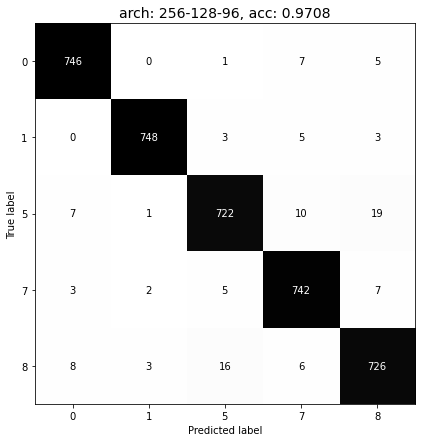

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix

best_arch = '256-128-96'
best_red = 32
best_model = tf.keras.models.load_model(
            f'models/Q33/{best_red}-{best_arch}.tf')

test_pred = best_model.predict(get_reduced_representation(best_red, test_vectors))
pred_class_test = np.argmax(test_pred, axis=1)

test_score = accuracy_score(test_vectors[1].numpy(), pred_class_test)

print('confusion matrix (test):')
fig = plt.figure(figsize=(7, 7))
#fig.suptitle('Confusion Matrix (Test Set)', y=0.04, fontsize=15)
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(test_vectors[1].numpy(), pred_class_test), display_labels=['0', '1', '5', '7', '8'])
cm_display.plot(ax = ax, cmap='Greys', colorbar=False)
ax.set_title(f'arch: {best_arch}, acc: {np.round(test_score, 4)}', fontdict = {'fontsize':14}, )
plt.show()

In [11]:
def get_reduced_representation(dim, vec):
    models = os.listdir('./models/Q22')
    model_path = str
    for model in models:
        if( ("3_hidden" in model) and ((str(dim)+"_n") in model)) : model_path = model
    loaded_model = tf.keras.models.load_model(os.path.join('./models/Q22', model_path))
    hidden_layer_model = tf.keras.models.Model(inputs=loaded_model.input, outputs=loaded_model.layers[2].output)
    hidden_output = hidden_layer_model.predict(vec[0].numpy().reshape(len(vec[0]),784))
    return hidden_output

In [12]:
model_arch = [
    [96, 64, 32],
    [64, 96, 128],
    [128, 96, 64],
    [256, 128, 96]
]
initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

k=5 # no. of classes
model_history = dict()

# train different achitectures and optimizers
print('Training models with different architectures')
for reduced_dimension in [32,64,128,256]:
    reduced_rep_train = get_reduced_representation(reduced_dimension, train_vectors)
    reduced_rep_val = get_reduced_representation(reduced_dimension, val_vectors)
    for layer_dims in model_arch:
        print(f'{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}...')
        # define model
        model = Sequential([
            layers.Dense(reduced_dimension, activation="relu", input_shape=(reduced_dimension,)),
            # keras.Input(input_shape=(reduced_dimension,)),
            layers.Dense(layer_dims[0], activation="tanh", name="layer1", 
                         kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
            layers.Dense(layer_dims[1], activation="tanh", name="layer2", 
                         kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
            layers.Dense(layer_dims[2], activation="tanh", name="layer3", 
                         kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
            # layers.Dense(layer_dims[3], activation="sigmoid", name="layer4", 
            #              kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
            layers.Dense(k, activation="softmax", name="output", 
                         kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        ])
        
        # compile model
        adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
        model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # callbacks
        my_callbacks = [
            EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=10),
            TensorBoard(log_dir=f'./logdir/Q44/{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}/')
        ]
        model_fit = model.fit(reduced_rep_train, train_vectors[1].numpy(), batch_size=len(train_vectors[0]), epochs=10000, verbose=0, callbacks=my_callbacks, 
                              validation_split=0.0, validation_data=(reduced_rep_val, val_vectors[1].numpy()), shuffle=True, validation_batch_size=None)
        
        model_history[f'{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}'] = model_fit.history['accuracy']
        
        hist_metric = 'accuracy'
        print(f'epochs: {len(model_fit.history[hist_metric])}, acc: {model_fit.history[hist_metric][-1]}\n')
        model.save(f'models/Q44/{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}.tf')

Training models with different architectures
119/119 [==============================] - 0s 3ms/step
32-96-64-32...
epochs: 432, acc: 0.9951691031455994

32-64-96-128...
epochs: 375, acc: 0.9952569007873535

32-128-96-64...
epochs: 321, acc: 0.991655707359314

32-256-128-96...
epochs: 306, acc: 0.9934123754501343

119/119 [==============================] - 1s 4ms/step
64-96-64-32...
epochs: 367, acc: 0.9995608329772949

64-64-96-128...
epochs: 265, acc: 0.9989460110664368

64-128-96-64...
epochs: 313, acc: 0.9995608329772949

64-256-128-96...
epochs: 207, acc: 0.9980676174163818

119/119 [==============================] - 0s 4ms/step
128-96-64-32...
epochs: 256, acc: 0.9992973208427429

128-64-96-128...
epochs: 179, acc: 0.999472975730896

128-128-96-64...
epochs: 254, acc: 0.9998243451118469

128-256-128-96...
epochs: 178, acc: 0.9998243451118469

119/119 [==============================] - 1s 4ms/step
256-96-64-32...
epochs: 266, acc: 0.9995608329772949

256-64-96-128...
epochs: 155, a

In [13]:
model_arch = [
    [96, 64, 32],
    [64, 96, 128],
    [128, 96, 64],
    [256, 128, 96]
]
initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

k=5 # no. of classes
for reduced_dimension in [32,64,128,256]:
    reduced_rep_train = get_reduced_representation(reduced_dimension, train_vectors)
    reduced_rep_val = get_reduced_representation(reduced_dimension, val_vectors)
    reduced_rep_test = get_reduced_representation(reduced_dimension, test_vectors)
    for layer_dims in model_arch:
        print(f'{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}...')
        
        model_path = f'models/Q44/{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}.tf'
        model = tf.keras.models.load_model(model_path)
        
        model.evaluate(reduced_rep_train,train_vectors[1].numpy())
        model.evaluate(reduced_rep_val,val_vectors[1].numpy())    
        model.evaluate(reduced_rep_test,test_vectors[1].numpy())  

119/119 [==============================] - 0s 4ms/step
32-96-64-32...
119/119 [==============================] - 0s 2ms/step - loss: 0.0763 - accuracy: 0.9781
32-64-96-128...
119/119 [==============================] - 0s 2ms/step - loss: 0.0923 - accuracy: 0.9752
32-128-96-64...
119/119 [==============================] - 0s 3ms/step - loss: 0.0970 - accuracy: 0.9736
32-256-128-96...
119/119 [==============================] - 0s 4ms/step
64-96-64-32...
119/119 [==============================] - 0s 2ms/step - loss: 0.0787 - accuracy: 0.9808
64-64-96-128...
119/119 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9792
64-128-96-64...
119/119 [==============================] - 0s 3ms/step - loss: 0.0745 - accuracy: 0.9789
64-256-128-96...
119/119 [==============================] - 0s 4ms/step
128-96-64-32...
119/119 [==============================] - 0s 3ms/step - loss: 0.0781 - accuracy: 0.9829
128-64-96-128...
119/119 [==============================] - 0s 2ms/s